In [ ]:
# Investigating which classes suffer from test-time augmentation,
# and why
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')
from dataloaders import get_flowers_dataloader
from utils.gpu_utils import restrict_GPU_pytorch
restrict_GPU_pytorch('0')

import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from imagenet_classes import imagenet_classes


sns.set_style('white')
n_classes = 102
model_name = 'resnet18'
hf = h5py.File('../flowers102/five_crop_hflip_scale/model_outputs/val/' + model_name + '.h5', 'r')
outputs = []
labels = []
# sort keys so that the order matches the dataloader
def sort_keys(keys):
    key_ints = [int(k.split('_')[1]) for k in keys]
    return sorted(list(set(key_ints)))
sorted_keys = sort_keys(hf.keys())
for key in sorted_keys:
    batch_key = 'batch_' + str(key) + "_inputs"
    label_key = 'batch_' + str(key) + "_labels"
    outputs.append(hf[batch_key][:])
    labels.append(hf[label_key][:])
outputs = np.concatenate(outputs, axis=1)
labels = np.concatenate(labels)

In [ ]:
# standard TTA errors
stta_preds = np.mean(outputs, axis=0)
orig_preds = outputs[12,:,:]

In [ ]:
stta_correct_idxs = np.where(np.argmax(stta_preds, axis=1) == labels)[0]
stta_incorrect_idxs = np.where(np.argmax(stta_preds, axis=1) != labels)[0]
orig_correct_idxs = np.where(np.argmax(orig_preds, axis=1) == labels)[0]
orig_incorrect_idxs = np.where(np.argmax(orig_preds, axis=1) != labels)[0]

In [ ]:
print("Original accuracy: ", len(orig_correct_idxs)/len(orig_preds))
print("Standard test-time augmentation accuracy: ", (len(stta_correct_idxs))/len(orig_preds))

In [ ]:
corruptions = set(stta_incorrect_idxs).intersection(orig_correct_idxs)
corrections = set(stta_correct_idxs).intersection(orig_incorrect_idxs)

In [ ]:
len(corruptions), len(corrections)

In [ ]:
corrected_class_map = Counter(labels[list(corrections)])
corrupted_class_map = Counter(labels[list(corruptions)])
net_stta_improvement = {}
for k in corrected_class_map.keys():
    if k in corrupted_class_map:
        net_stta_improvement[k] = corrected_class_map[k] - corrupted_class_map[k]
    else:
        net_stta_improvement[k] = corrected_class_map[k]
for k in corrupted_class_map.keys():
    if k not in net_stta_improvement:
        net_stta_improvement[k] = 0 - corrupted_class_map[k]


In [ ]:
stta_order = sorted(net_stta_improvement, key= net_stta_improvement.get)
flowers_classes = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

In [ ]:
dl = get_flowers_dataloader(False, False, 64)
#>=6% decrease in accuracy, up to 10%
harmed_class_names = [flowers_classes[int(i)] for i in stta_order[:15]]
harmed_class_nums = [net_stta_improvement[i] for i in stta_order[:15]]
#>10\% improvement in accuracy (up to 20\%)
helped_class_names = [flowers_classes[int(i)] for i in stta_order[-15:]]
helped_class_nums = [net_stta_improvement[i] for i in stta_order[-15:]]

In [ ]:
def unnormalize_imnet(img):
    std = [0.229, 0.224, 0.225]
    img = img * np.array(std)
    mean = [0.485, 0.456, 0.406]
    img = img + np.array(mean)
    return img

def unnormalize_flowers(img):
    std = [0.2944, 0.2465, 0.2735]
    img = img * np.array(std)
    mean = [0.5208, 0.4205, 0.3441]
    img = img + np.array(mean)
    return img

In [ ]:
from tqdm.notebook import tqdm
harmed_class_labels = []
harmed_class_images = []
helped_class_labels = []
helped_class_images = []
corrupted_images, corrupted_labels = [], []
corrected_images, corrected_labels = [], []
all_y = []
batch_num = 0
batch_size = 64
for X, y in tqdm(dl):
    for i in range(len(X)):
        global_i = batch_num*batch_size + i
        if global_i in corrections:
            corrected_images.append(X[i])
            corrected_labels.append(y[i])
        elif global_i in corruptions:
            corrupted_images.append(X[i])
            corrupted_labels.append(y[i])
        if y[i] in stta_order[-15:]:
            helped_class_images.append(X[i])
            helped_class_labels.append(y[i])
        elif y[i] in stta_order[:15]:
            harmed_class_images.append(X[i])
            harmed_class_labels.append(y[i])
    batch_num += 1
helped_class_labels = [l.item() for l in helped_class_labels]
harmed_class_labels = [l.item() for l in harmed_class_labels]
helped_class_images = [i.cpu().numpy() for i in helped_class_images]
harmed_class_images = [i.cpu().numpy() for i in harmed_class_images]

# Examples of corrupted images 

In [ ]:
corrupted_labels = [l.item() for l in corrupted_labels]
corrected_labels = [l.item() for l in corrected_labels]
corrupted_images = [i.cpu().numpy() for i in corrupted_images]
corrected_images = [i.cpu().numpy() for i in corrected_images]
corrections = sorted(list(corrections))
corruptions = sorted(list(corruptions))

In [ ]:
plt.figure()
n_harmed = len(corruptions)
idxs = np.random.choice(list(range(n_harmed)), 25, replace=False)
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(20, 20))
for i, idx in enumerate(idxs):
    ax = axs[int(i/5), i%5]
    img = np.transpose(corrupted_images[idx], (1, 2, 0))
    img = unnormalize_imnet(img)
    stta_label = flowers_classes[np.argmax(stta_preds[corruptions[idx]], axis=0)].split(',')[0]
    orig_pred = flowers_classes[np.argmax(orig_preds[corruptions[idx]], axis=0)].split(',')[0]
    orig_label = flowers_classes[corrupted_labels[idx]].split(',')[0]
    ax.set_title("Orig: " +  orig_pred + " STTA: " +stta_label)
    # to get TTA change, then....
    ax.imshow((img*255).astype(np.uint8))
    ax.axis('off')
plt.tight_layout()

# Examples of corrected images

In [ ]:
plt.figure()
n_helped = len(corrections)
idxs = np.random.choice(list(range(n_helped)), 25, replace=False)
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(20, 20))
for i, idx in enumerate(idxs):
    ax = axs[int(i/5), i%5]
    img = np.transpose(corrected_images[idx], (1, 2, 0))
    img = unnormalize_imnet(img)
    stta_label = flowers_classes[np.argmax(stta_preds[corrections[idx]], axis=0)].split(',')[0]
    orig_pred = flowers_classes[np.argmax(orig_preds[corrections[idx]], axis=0)].split(',')[0]
    orig_label = flowers_classes[corrected_labels[idx]].split(',')[0]
    ax.set_title("Orig: " +  orig_pred + " STTA: " +stta_label)
    # to get TTA change, then....
    ax.imshow((img*255).astype(np.uint8))
    ax.axis('off')
plt.tight_layout()

# Class-specific trends

<Figure size 432x288 with 0 Axes>

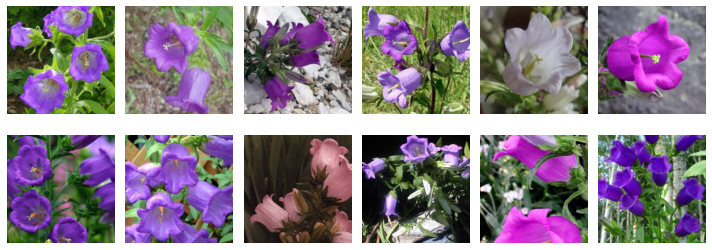

<Figure size 432x288 with 0 Axes>

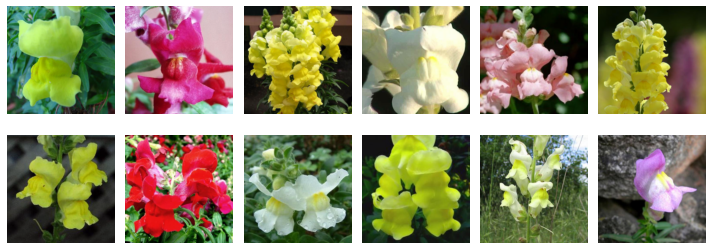

<Figure size 432x288 with 0 Axes>

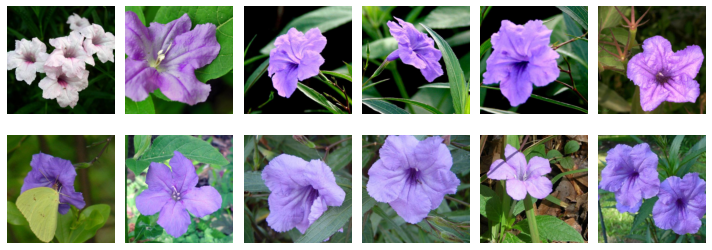

<Figure size 432x288 with 0 Axes>

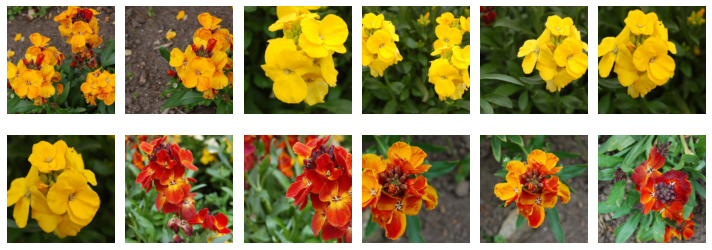

<Figure size 432x288 with 0 Axes>

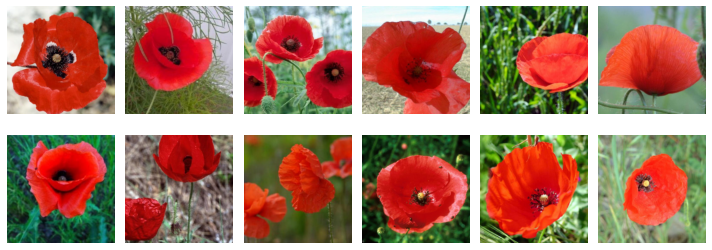

<Figure size 432x288 with 0 Axes>

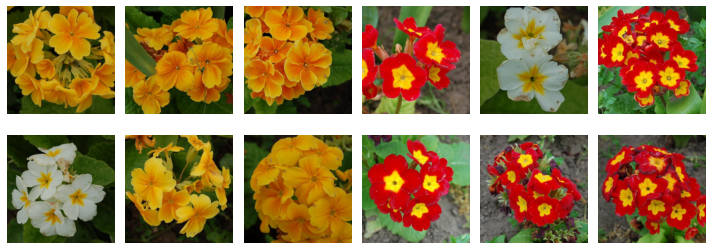

<Figure size 432x288 with 0 Axes>

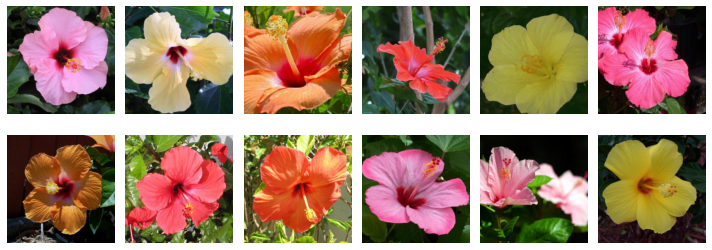

<Figure size 432x288 with 0 Axes>

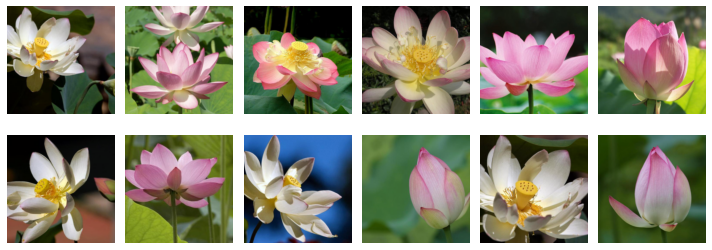

<Figure size 432x288 with 0 Axes>

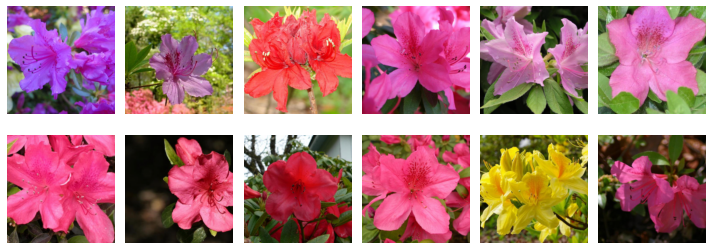

<Figure size 432x288 with 0 Axes>

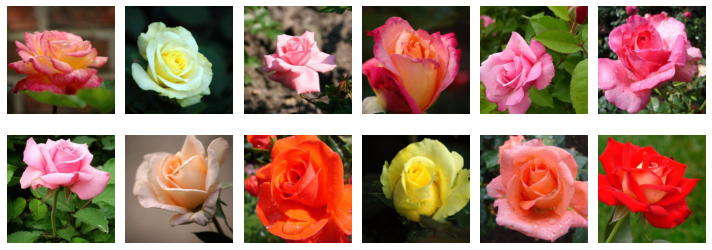

In [15]:
n_images = 12
for j in range(10):
    plt.figure()
    fig, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(10, 4))
    label = stta_order[-10:][j]
    plot_idxs = np.where(helped_class_labels == label)[0]
    for i in range(n_images):
        ax = axs[int(i/6), i%6]
        img = np.transpose(helped_class_images[plot_idxs[i]], (1, 2, 0))
        img = unnormalize_flowers(img)
        ax.imshow((img*255).astype(np.uint8))
        #ax.set_title(flowers_classes[int(label)])
        ax.axis('off')
        plt.tight_layout()

<Figure size 432x288 with 0 Axes>

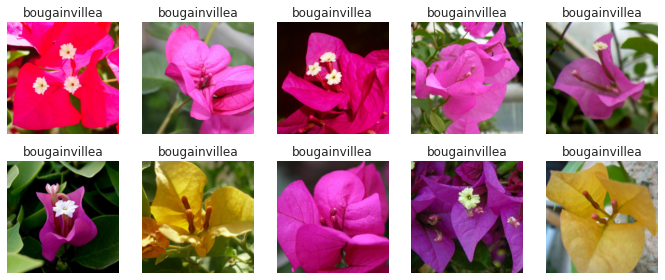

<Figure size 432x288 with 0 Axes>

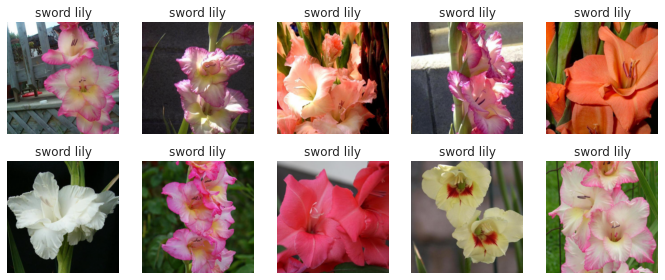

<Figure size 432x288 with 0 Axes>

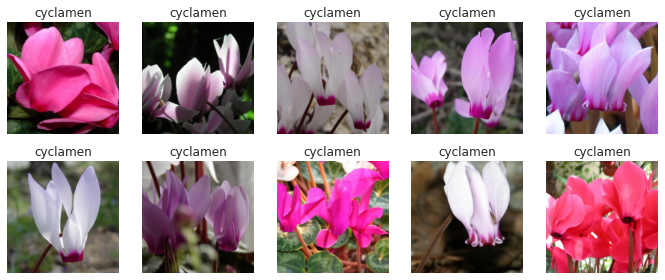

<Figure size 432x288 with 0 Axes>

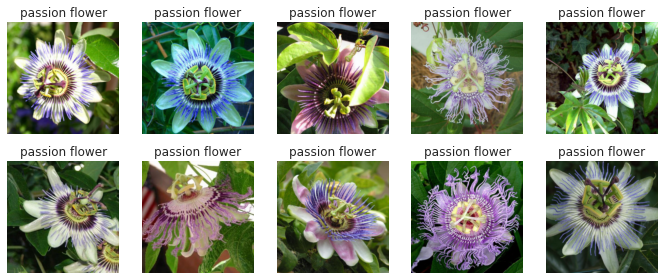

<Figure size 432x288 with 0 Axes>

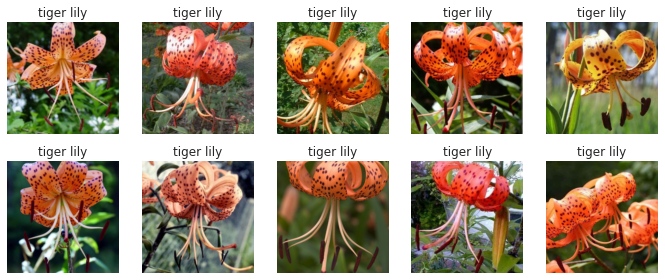

<Figure size 432x288 with 0 Axes>

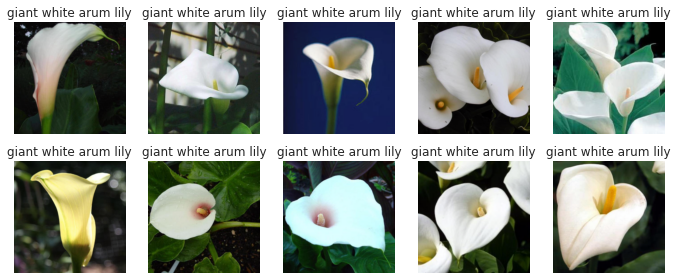

<Figure size 432x288 with 0 Axes>

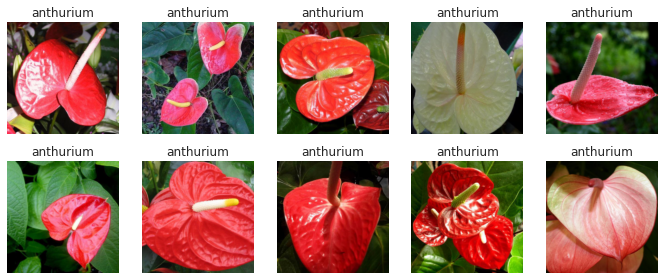

<Figure size 432x288 with 0 Axes>

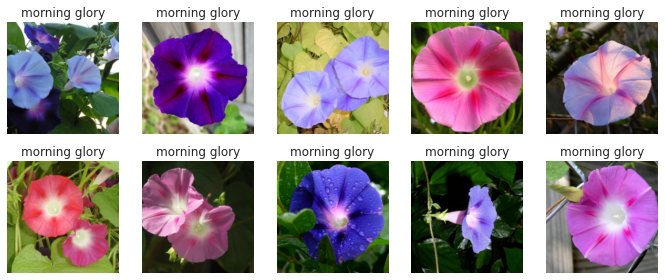

<Figure size 432x288 with 0 Axes>

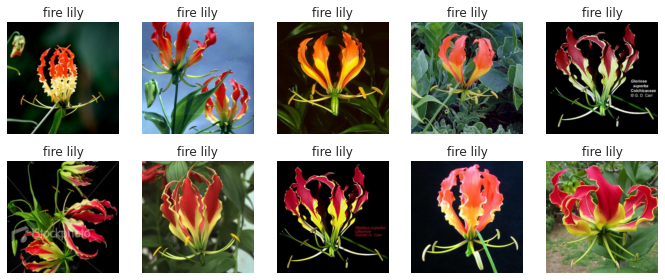

<Figure size 432x288 with 0 Axes>

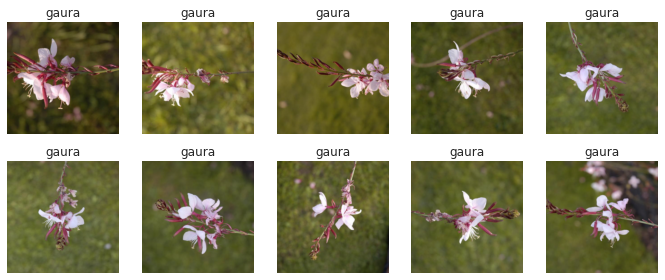

In [16]:
n_images = 10
for j in range(10):
    plt.figure()
    fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10, 4))

    label = stta_order[:15][j]
    plot_idxs = np.where(harmed_class_labels == label)[0]
    plt.title(flowers_classes[int(label)])
    for i in range(n_images):
        ax = axs[int(i/5), i%5]
        img = np.transpose(harmed_class_images[plot_idxs[i]], (1, 2, 0))
        img = unnormalize_flowers(img)
        ax.imshow((img*255).astype(np.uint8))
        ax.set_title(flowers_classes[int(label)])

        ax.axis('off')
        plt.tight_layout()

In [17]:
helped_class_names, stta_order[-15:]

(['ball moss',
  'foxglove',
  'magnolia',
  'artichoke',
  'japanese anemone',
  'canterbury bells',
  'snapdragon',
  'mexican petunia',
  'wallflower',
  'corn poppy',
  'primula',
  'hibiscus',
  'lotus',
  'azalea',
  'rose'],
 [92.0,
  93.0,
  86.0,
  28.0,
  61.0,
  2.0,
  10.0,
  97.0,
  45.0,
  25.0,
  52.0,
  82.0,
  77.0,
  71.0,
  73.0])

In [18]:
harmed_class_names, stta_order[:15]

(['bougainvillea',
  'sword lily',
  'cyclamen',
  'passion flower',
  'tiger lily',
  'giant white arum lily',
  'anthurium',
  'morning glory',
  'fire lily',
  'gaura',
  'ruby-lipped cattleya',
  'tree mallow',
  'bolero deep blue',
  'moon orchid',
  'buttercup'],
 [94.0,
  42.0,
  87.0,
  76.0,
  5.0,
  19.0,
  79.0,
  75.0,
  20.0,
  56.0,
  35.0,
  85.0,
  44.0,
  6.0,
  47.0])

# Why does test-time augmentation work for roses and not bougainvalleas?

In [ ]:
corrections_list = np.array(list(corrections))

rose_class_idx = stta_order[-15:][-1]
rose_idxs = np.where(corrected_labels == rose_class_idx)[0]
global_rose_idxs = corrections_list[rose_idxs]

rose_images = [corrected_images[i] for i in rose_idxs]
rose_tta_preds = stta_preds[global_rose_idxs,:]
rose_orig_preds = orig_preds[global_rose_idxs,:]
rose_labels = np.array(corrected_labels)[rose_idxs]
jj = labels[global_rose_idxs]
# which bougainvaleas does TTA mess up? with which classes?

In [ ]:
print(','.join([flowers_classes[i] for i in np.argmax(rose_orig_preds, axis=1)]))
fig, axs = plt.subplots(1, 7, figsize=(28, 5))
for i in range(len(axs)):
    ax = axs[i]
    img = rose_images[i]
    img = np.transpose(img, (1, 2, 0))
    img = unnormalize_flowers(img)
    ax.imshow((img*255).astype(np.uint8))
    ax.axis('off')
plt.tight_layout()

In [ ]:
corruptions_list = np.array(list(corruptions))

bv_class_idx = stta_order[:15][0]
bv_idxs = np.where(corrupted_labels == bv_class_idx)[0]
global_bv_idxs = corruptions_list[bv_idxs]

bv_images = [corrupted_images[i] for i in bv_idxs]
bv_tta_preds = stta_preds[global_bv_idxs,:]
bv_orig_preds = orig_preds[global_bv_idxs,:]
bv_labels = np.array(corrected_labels)[bv_idxs]
jj = labels[global_bv_idxs]
# which bougainvaleas does TTA mess up? with which classes?

In [ ]:
print(','.join([flowers_classes[i] for i in np.argmax(bv_tta_preds, axis=1)]))
fig, axs = plt.subplots(1, 7, figsize=(28, 5))
for i in range(len(axs)):
    ax = axs[i]
    img = bv_images[i%5]
    img = np.transpose(img, (1, 2, 0))
    img = unnormalize_flowers(img)
    ax.imshow((img*255).astype(np.uint8))
    ax.axis('off')
plt.tight_layout()

# Looking at what happens to augmentation predictions when label is corrupted

In [98]:
# what labels are refrigerator, breastplate, and shower cap mistaken for? 
# what lables are the helped classes mistaken for?
corruptions_list = list(corruptions)
corrections_list = list(corrections)
idx_list = corruptions_list
outputs_ta = outputs[:,idx_list,:] 
orig_preds_ta = orig_preds[idx_list,:]
labels_ta = labels[idx_list]

In [99]:
# Indices with respect to corruptions_list
class_opt = stta_order[:15][0]
#class_opt = stta_order[-15:][-1]

class_name = flowers_classes[int(class_opt)]
class_idxs = np.where(np.array(labels[idx_list]) == class_opt)[0]
# Indices with respect to full dataset
class_idxs = [idx_list[i] for i in class_idxs]

outputs_ta = outputs[:,class_idxs,:]
orig_preds_ta = orig_preds[class_idxs,:]
print([flowers_classes[int(i)] for i in np.argmax(np.mean(outputs_ta, axis=0), axis=1)])
print([flowers_classes[int(class_opt)]])
print([flowers_classes[int(i)] for i in np.argmax(orig_preds_ta, axis=1)])

['mallow', 'mallow', 'poinsettia', 'poinsettia', 'poinsettia']
['bougainvillea']
['bougainvillea', 'bougainvillea', 'bougainvillea', 'bougainvillea', 'bougainvillea']


In [100]:
%load_ext autoreload
%autoreload 2
from utils.aug_utils import invert_aug_list
aug_list = np.load('../' + 'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_list.npy')
aug_order = np.load('../' +'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_order.npy')
aug_names = invert_aug_list(aug_list, aug_order)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
jj = outputs_ta[:,img_idx,:]
print(np.argmax(np.mean(jj, axis=0)), stta_order[0])
print(np.argsort(np.mean(jj, axis=0)))

43 94.0
[ 11   9   4  16   5  70  13  34  80  40  48  58  53  36  62  65  99  78
  66  22   8   7 101  20  60  51  24  61  19  56  49  63  28  37  47  57
  14  64  90  30  55  23  59  76  45  79  46  92  25  12  67   1  98  84
  17  68  85  21  91  42  18  27  89 100  32  77  73  87  39  86  10  93
  69  29  26  33  88  41   2  31  44   6  15  38  96  83  35  72   0  81
  82  97   3  75  52  54  50  95  71  74  94  43]


Text(0.5, 1.0, 'Heat map of logit outputs for 10 most likely classes (true class=bougainvillea, \n for each test time augmentation')

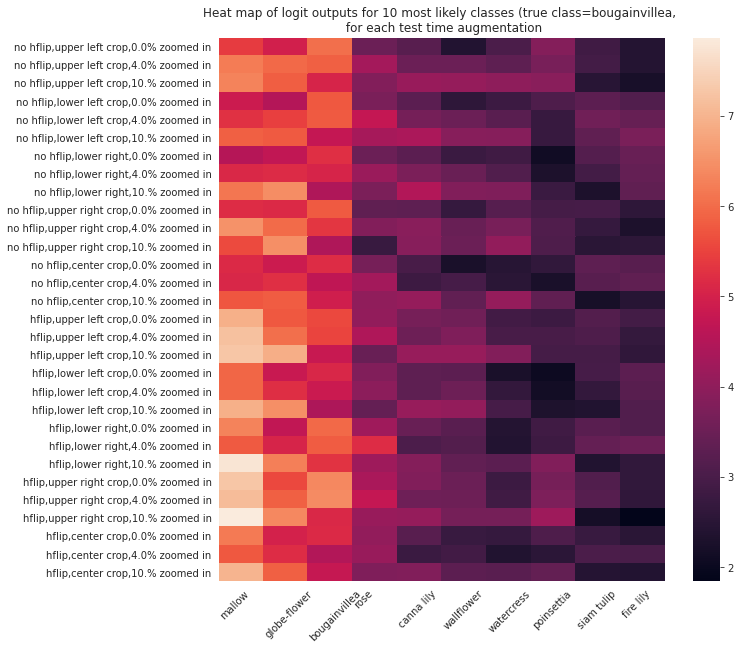

In [118]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.set_style('white')
img_idx = 1
img_output = outputs_ta[:,img_idx,:]
most_likely_classes = np.argsort(np.mean(img_output, axis=0))[-10:]
most_likely_classes = np.flip(most_likely_classes, axis=0)
img_output = img_output[:,most_likely_classes]
ax = sns.heatmap(img_output)
plt.xticks(list(range(10)), [flowers_classes[int(i)] for i in most_likely_classes],  
           rotation = 45, ha="left")
ax.set_yticklabels(aug_names, ha='right')
plt.yticks(rotation=0)
plt.title("Heat map of logit outputs for 10 most likely classes (true class=" + \
          class_name.split(',')[0] + ", \n for each test time augmentation")

In [24]:
# grouped bar plot across classes 
from scipy.stats import pearsonr
n_classes = 102
class_acc = np.zeros(n_classes)
for i in range(n_classes):
    class_idxs = np.where(labels == i)[0]
    n_correct = len(set(class_idxs).intersection(orig_correct_idxs))
    class_acc[i] = n_correct/len(class_idxs)

stta_class_acc = np.zeros(n_classes)
for i in range(n_classes):
    class_idxs = np.where(labels == i)[0]
    n_correct = len(set(class_idxs).intersection(stta_correct_idxs))
    stta_class_acc[i] = n_correct/len(class_idxs)

    
class_stta_improvement_list = np.zeros(n_classes)
for i in range(n_classes):
    if i not in net_stta_improvement:
        class_stta_improvement_list[i] = 0
    else:
        class_stta_improvement_list[i] = net_stta_improvement[i]

print(pearsonr(class_acc, class_stta_improvement_list))
# calculate each class's accuracy from orig_preds and labels
# create accuracy map 
# iterate over net_stta_improvement and class_acc 

(-0.26818989376337915, 0.006423932543409486)


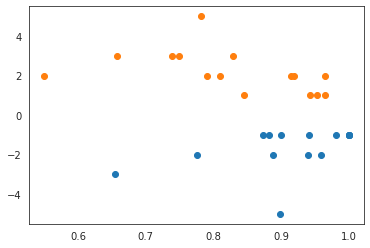

In [25]:
#plt.scatter(class_acc, class_stta_improvement_list)
plt.scatter(class_acc[np.array(stta_order[:15]).astype(int)], 
            class_stta_improvement_list[np.array(stta_order[:15]).astype(int)])
plt.scatter(class_acc[np.array(stta_order[-15:]).astype(int)], 
            class_stta_improvement_list[np.array(stta_order[-15:]).astype(int)])

In [54]:
class_acc[np.array(stta_order[:15]).astype(int)[1]]
stta_class_acc[np.array(stta_order[:15]).astype(int)[1]]

0.6272727272727273

In [43]:
flowers_classes[np.array(stta_order[:15]).astype(int)[1]]
flowers_classes[np.array(stta_order[-15:]).astype(int)[10]]

'primula'

In [56]:
class_acc[np.array(stta_order[-15:]).astype(int)[10]]
#stta_class_acc[np.array(stta_order[-15:]).astype(int)[10]]

0.6575342465753424

Text(0.5, 1.0, 'Effect of Standard TTA on Flowers102')

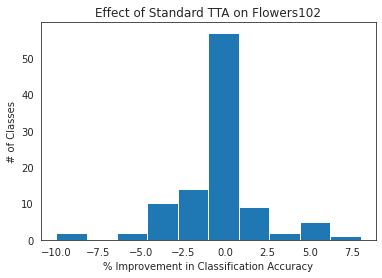

In [27]:
plt.hist(100*(class_acc - stta_class_acc))
plt.xlabel("% Improvement in Classification Accuracy")
plt.ylabel("# of Classes")
class_acc[np.array(stta_order[:15]).astype(int)]

In [83]:
class_acc[np.array(stta_order[:15]).astype(int)]

array([0.89814815, 0.65454545, 0.7761194 , 0.96      , 0.88888889,
       0.93939394, 0.87356322, 0.88235294, 1.        , 0.98181818,
       0.94117647, 1.        , 1.        , 0.9       , 0.97      ])

# See what our model does to decisions for different classes

In [84]:
# What classes does test-time augmentation corrupt?
# Get idxs that standard TTA corrupts
# What is the performance of our method on images that test-time augmentation corrupts?
# how does partial LR fix this?
# how does full LR address this?
# What classes does our method correct? 